In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [37]:
# стиль графиков
sns.set_theme(style="whitegrid")

In [38]:
# задание а
def initial_analysis():
    try:
        df = pd.read_csv('google_books_dataset.csv')
    except FileNotFoundError:
        print("файла нет")
        return None

    print("--- начало таблицы (первые 2 строки) ---")
    print(df.head(2))

    print("\n--- конец таблицы (последние строки) ---")
    print(df.tail(2))

    print("\n--- типы данных ---")
    print(df.info())

    # фиксим типы данных
    df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
    df['page_count'] = pd.to_numeric(df['page_count'], errors='coerce')
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')

    return df

In [39]:
# задание б чистим мусор
def clean_data(df):
    print("\n--- пропуски ---")
    print(df.isnull().sum())

    # убираем пустые данные
    df['subtitle'] = df['subtitle'].fillna('No Subtitle')
    df['description'] = df['description'].fillna('No Description')
    df['categories'] = df['categories'].fillna('Uncategorized')

    # числа заполним медианой
    df['average_rating'] = df['average_rating'].fillna(df['average_rating'].median())
    df['ratings_count'] = df['ratings_count'].fillna(0)
    df['page_count'] = df['page_count'].fillna(df['page_count'].median())

    # убираем повторы
    duplicate_count = df.duplicated().sum()
    print(f"\nповторов найдено: {duplicate_count}")
    if duplicate_count > 0:
        df = df.drop_duplicates()

    # ищем странные значения через z-score
    z_scores = np.abs(stats.zscore(df['page_count']))
    outliers = np.where(z_scores > 3)
    print(f"странных значений: {len(outliers[0])}")

    # описание
    print("\n--- описание ---")
    print(df.describe())

    print("\n--- корреляция ---")
    numeric_df = df.select_dtypes(include=[np.number])
    print(numeric_df.corr())

    return df

In [40]:
# задание в: графиуи
def visualize_data(df):
    plt.figure(figsize=(15, 12))

    # 1. гистограмма по рейтингам
    plt.subplot(3, 2, 1)
    sns.histplot(df['average_rating'], kde=True, color='skyblue')
    plt.title('распределение рейтингов')

    # 2. линейный график по годам
    plt.subplot(3, 2, 2)
    df['year'] = df['published_date'].dt.year
    books_per_year = df.groupby('year').size().tail(20)
    books_per_year.plot(kind='line', marker='o', color='green')
    plt.title('сколько книг выходило в год')

    # 3. столбцы по категориям
    plt.subplot(3, 2, 3)
    df['categories'].value_counts().head(10).plot(kind='bar', color='orange')
    plt.title('топ 10 категорий')
    plt.xticks(rotation=45)

    # 4. ящик с усами для страниц
    plt.subplot(3, 2, 4)
    sns.boxplot(x=df['page_count'])
    plt.title('странные значения по страницам')

    # 5. хитмап связей
    plt.subplot(3, 2, 5)
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('карта корреляций')

    plt.tight_layout()
    plt.show()

In [41]:
# задание г: группировка и счёт
def perform_aggregations(df):
    print("\n--- агрегации ---")

    # 1. стата по языкам
    lang_stats = df.groupby('language')['average_rating'].agg(['mean', 'median', 'count'])
    print("\nрейтинги по языкам:")
    print(lang_stats.head())

    # 2. сумма страниц по жанрам
    cat_pages = df.groupby('categories')['page_count'].sum().sort_values(ascending=False)
    print("\nсамые большие категории:")
    print(cat_pages.head())

    # 3. сводная таблица (язык / категория / рейтинг)
    pivot = df.pivot_table(index='categories', columns='language', values='average_rating', aggfunc='mean').fillna(0)
    print("\nчасть сводной таблицы:")
    print(pivot.iloc[:5, :5])

    return lang_stats

--- начало таблицы (первые 2 строки) ---
        book_id        title  \
0  LR_VDQAAQBAJ  Bestsellers   
1  WcjTDQAAQBAJ  Bestsellers   

                                            subtitle                 authors  \
0  The Path (bestsellers, free bestsellers, bests...  Ivan King, bestsellers   
1  Hell: A Place Without Hope (bestseller books, ...  Ivan King, bestsellers   

     publisher published_date  \
0  bestsellers     2017-01-04   
1  bestsellers     2017-01-03   

                                         description  page_count  \
0  Hear What the Critics are Saying "Wow, what an...        70.0   
1  Hear What the Critics are Saying Wow, very ins...        32.0   

                categories  average_rating  ...  language  \
0      Young Adult Fiction             NaN  ...        en   
1  Comics & Graphic Novels             NaN  ...        en   

                                        preview_link  \
0  http://books.google.com/books?id=LR_VDQAAQBAJ&...   
1  http://books.goog

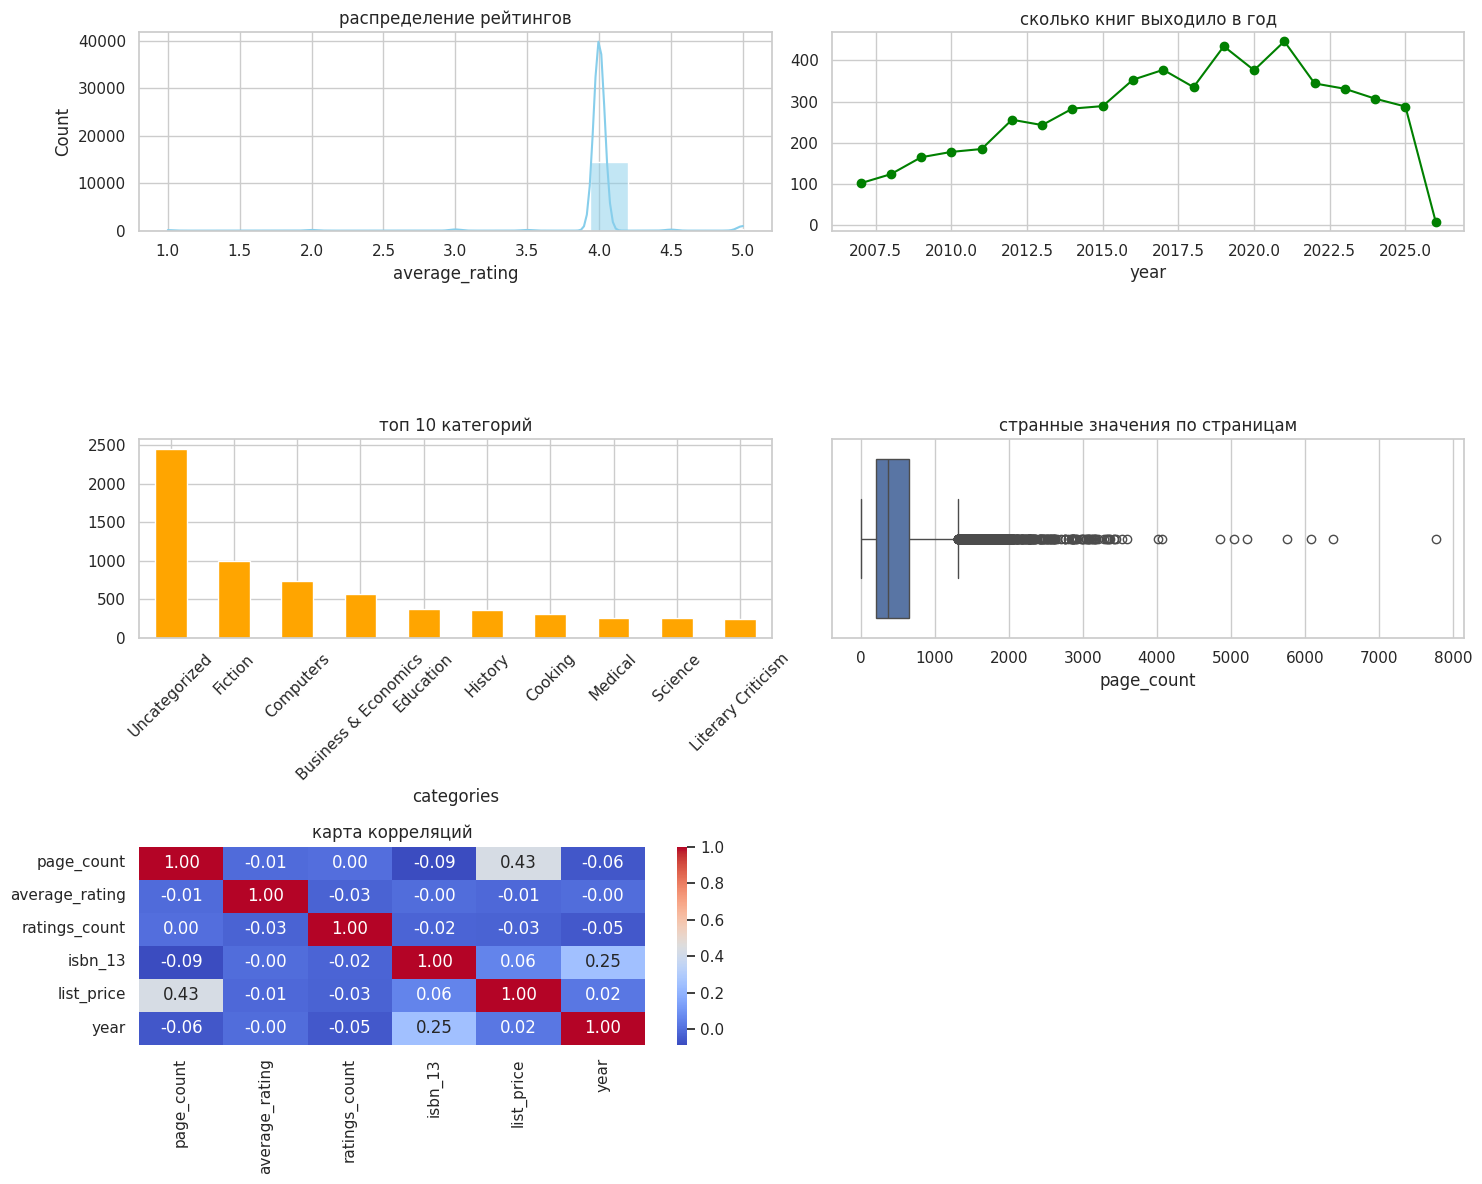


--- агрегации ---

рейтинги по языкам:
              mean  median  count
language                         
ar        4.000000     4.0      1
bs        4.000000     4.0      1
ca        4.000000     4.0      5
cs        3.833333     4.0      6
da        4.000000     4.0      8

самые большие категории:
categories
Uncategorized           1126226.0
Fiction                  351503.0
Computers                321817.0
Business & Economics     198863.0
Education                180891.0
Name: page_count, dtype: float64

часть сводной таблицы:
language                  ar   bs   ca   cs   da
categories                                      
1941                     0.0  0.0  0.0  0.0  0.0
35mm cameras             0.0  0.0  0.0  0.0  0.0
4-H clubs                0.0  0.0  0.0  0.0  0.0
ANTIQUES & COLLECTIBLES  0.0  0.0  0.0  0.0  0.0
Abbreviations, French    0.0  0.0  0.0  0.0  0.0

файл сохранен


In [42]:
# запуск
if __name__ == "__main__":

    data = initial_analysis()
    if data is not None:
        cleaned_data = clean_data(data)
        visualize_data(cleaned_data)
        perform_aggregations(cleaned_data)

        # сохраняем для дашборда
        cleaned_data.to_csv('cleaned_google_books.csv', index=False)
        print("\nфайл сохранен")